#### Import the libraries and load the data

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
onlineData = pd.read_excel('./Data/Online Retail.xlsx')
onlineData.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
onlineData.shape

(541909, 8)

The dataset contains 541,909 transactions.

#### Handling missing data

In [4]:
# check for missing values
onlineData.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

 Since we have sufficient data, we will drop all the rows with missing values.

In [5]:
# remove missing values
onlineData.dropna(inplace=True)

# again check missing values
onlineData.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Data preparation

Let's convert the StockCode to string datatype.

In [6]:
onlineData['StockCode']= onlineData['StockCode'].astype(str)

Let's check out the number of unique customers in our dataset.

In [7]:
customers = onlineData["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

We will use data of 90% of the customers to create word2vec embeddings and the rest for validation. Let's split the data.

In [8]:
# shuffle customer IDs
random.shuffle(customers)

# extract 90% of customer IDs
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = onlineData[onlineData['CustomerID'].isin(customers_train)]
validation_df = onlineData[~onlineData['CustomerID'].isin(customers_train)]

Let's create sequences of purchases made by the customers in the dataset for both the train and validation set.

In [9]:
# list to capture purchase history of the training set customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|█████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:08<00:00, 441.51it/s]


In [10]:
# list to capture purchase history of the validation set customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 673.50it/s]


#### Build word2vec embeddings for products

In [11]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha = 0.03, min_alpha = 0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, epochs = 10, report_delay = 1)

(3552437, 3590920)

In [12]:
# save word2vec model
model.save("word2vec_2.model")

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [13]:
model.init_sims(replace=True)
print(model)

Word2Vec(vocab=3156, size=100, alpha=0.03)


Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [14]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3156, 100)

#### Visualize word2vec embeddings 

For sake of visualization, we are going to reduce the dimensions of the product embeddings from 100 to 2 by using the UMAP algorithm, it is used for dimensionality reduction.

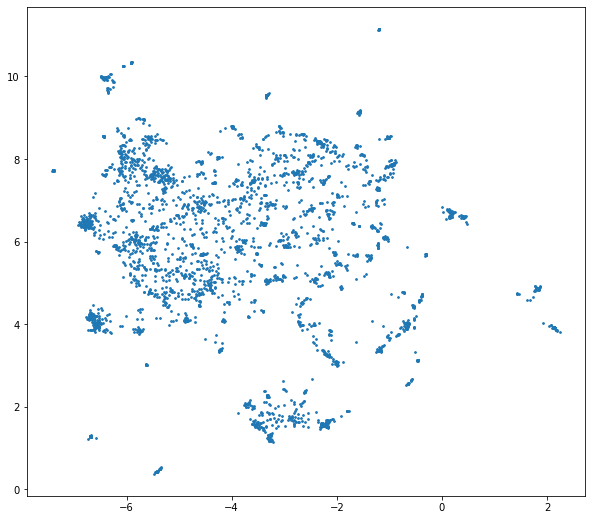

In [15]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Every dot in this plot is a product. There are several tiny clusters of these datapoints. These are groups of similar products.

#### Recommending Products

We are ready with the word2vec embeddings for every product in the online retail dataset. Now our next step is to suggest similar products for a certain product or a product's vector.

Let's first create a product-ID and product-description dictionary to easily map a product's description to its ID and vice versa.

In [16]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [17]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

Top 6 similar products

In [18]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn=n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms

Let's try out our function by passing the vector of the product '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [19]:
similar_products(model['90019A'])

[('ANT COPPER RED BOUDICCA BRACELET', 0.7822684645652771),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7656006217002869),
 ('PINK BOUDICCA LARGE BRACELET', 0.761540949344635),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7525368332862854),
 ('BLUE MURANO TWIST BRACELET', 0.7518712878227234),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7499581575393677)]

The results are pretty relevant and match well with the input product. However, this output is based on the vector of a single product only. What if we want recommend a user products based on the multiple purchases they have made in the past?

One simple solution is to take average of all the vectors of the products they bought so far and use this resultant vector to find similar products. For that we will use the function below that takes in a list of product IDs and gives out a 100 dimensional vector which is mean of vectors of the products in the input list.

In [20]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

We will pass this products' sequence of the validation set to the function aggregate_vectors.

In [21]:
similar_products(aggregate_vectors(purchases_val[0]))

[('CHOCOLATE HOT WATER BOTTLE', 0.653756856918335),
 ('HOT WATER BOTTLE KEEP CALM', 0.6459493041038513),
 ('HOT WATER BOTTLE I AM SO POORLY', 0.6394602060317993),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.6332569122314453),
 ('PLEASE ONE PERSON METAL SIGN', 0.6266429424285889),
 ("I'M ON HOLIDAY METAL SIGN", 0.6261299252510071)]

The system has recommended 6 products based on the entire purchase history of a user. Moreover, if you want to get products suggestions based on just the last few purchases then we can use the same set of functions.

For the last 10 products purchased as input:

In [22]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('HOT WATER BOTTLE TEA AND SYMPATHY', 0.8783085346221924),
 ('HOT WATER BOTTLE KEEP CALM', 0.8627409934997559),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.8611298203468323),
 ('HOT WATER BOTTLE I AM SO POORLY', 0.8423911333084106),
 ('RETROSPOT HEART HOT WATER BOTTLE', 0.8377293944358826),
 ('LOVE HOT WATER BOTTLE', 0.8100992441177368)]

We do see different products are recommended using the subset of the purchases history.